# Import Packages

In [132]:
import numpy as np
import matplotlib.pyplot as plt
import snntorch as snn
import snntorch.spikeplot as splt
import torch

from snntorch import spikegen
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from IPython.display import HTML

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class TouchDataset(Dataset):
    def __init__(self, root_dir, transform=None) -> None:
        data = np.load(root_dir, allow_pickle=True)
        sensordata = [np.array(data[k]['sensordata']) for k in data.keys()]
        orientation = [np.array(data[k]['orientations'])for k in data.keys()]
        self.sensordata, self.orientation = np.vstack(
            sensordata), np.hstack(orientation)
        self.transform = transform

    def __len__(self):
        return len(self.orientation)

    def __getitem__(self, index):
        sample = self.sensordata[index, :, :]
        if self.transform:
            sample = self.transform(sample)
        return sample, self.orientation[index]


class MinMaxScale(object):
    def __init__(self, minVal, maxVal):
        self.min, self.max = minVal, maxVal

    def __call__(self, x):
        min_x, max_x = np.min(x), np.max(x)
        y = (x - min_x)/(max_x - min_x)
        return y*(self.max - self.min) + self.min


# Encode Touch Dataset with Spikes

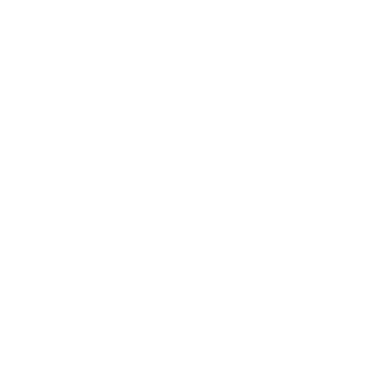

In [134]:
# Copyright 2022 wngfra.
# SPDX-License-Identifier: Apache-2.0
batch_size = 128
num_steps = 100

transform = transforms.Compose([
    MinMaxScale(0., 1.0),
    transforms.ToTensor()
])
touch_dataset = TouchDataset('../data/touch.pkl', transform=transform)
train_loader = DataLoader(touch_dataset, batch_size=batch_size, shuffle=True)

# Iterate through minibatches
data = iter(train_loader)
data_it, targets_it = next(data)

# Spiking Data
spike_data = spikegen.rate(data_it, num_steps=num_steps, gain=0.5)
fig, ax = plt.subplots()
anim = splt.animator(spike_data[:, 0, 0], fig, ax)
HTML(anim.to_html5_video())


# Reference
1. F. Pascal, L. Bombrun, J. -Y. Tourneret and Y. Berthoumieu, "Parameter Estimation For Multivariate Generalized Gaussian Distributions," in IEEE Transactions on Signal Processing, vol. 61, no. 23, pp. 5960-5971, Dec.1, 2013, doi: 10.1109/TSP.2013.2282909.
2. A. Parvizi-Fard, M. Amiri, D. Kumar, M. M. Iskarous, and N. V. Thakor, “A functional spiking neuronal network for tactile sensing pathway to process edge orientation,” Sci Rep, vol. 11, no. 1, p. 1320, Dec. 2021, doi: 10.1038/s41598-020-80132-4.
3. J. A. Pruszynski and R. S. Johansson, “Edge-orientation processing in first-order tactile neurons,” Nat Neurosci, vol. 17, no. 10, pp. 1404–1409, Oct. 2014, doi: 10.1038/nn.3804.
4. J. M. Yau, S. S. Kim, P. H. Thakur, and S. J. Bensmaia, “Feeling form: the neural basis of haptic shape perception,” Journal of Neurophysiology, vol. 115, no. 2, pp. 631–642, Feb. 2016, doi: 10.1152/jn.00598.2015.
5. G. Sutanto, Z. Su, S. Schaal, and F. Meier, “Learning Sensor Feedback Models from Demonstrations via Phase-Modulated Neural Networks,” in 2018 IEEE International Conference on Robotics and Automation (ICRA), Brisbane, QLD, May 2018, pp. 1142–1149. doi: 10.1109/ICRA.2018.8460986.